In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./datasets/Sentiment.csv')
df.head()

,id,sentiment,text
0,1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...
1,2,Positive,RT @RobGeorge: That Carly Fiorina is trending ...
2,3,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
3,4,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day ..."
4,5,Negative,RT @warriorwoman91: I liked her and was happy ...


In [3]:
# Preprocessing
import numpy as np

In [4]:
df['sentiment']=np.where(df.sentiment=='Positive',1,0)

In [5]:
# clean text
import re

In [12]:
text = df['text'][3]
print(text)

handle_regex = r'@([\S])+(:)*'
new_text = re.sub(handle_regex, '', text)
print(new_text)

RT @GregAbbott_TX: @TedCruz: "On my first day I will rescind every illegal executive action taken by Barack Obama." #GOPDebate @FoxNews
RT   "On my first day I will rescind every illegal executive action taken by Barack Obama." #GOPDebate 


In [9]:
# remove stop words as well
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielmatheison/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
stCol1 = stopwords.words('english')

In [26]:
def cleanText(text):
    # remove handles
    text=re.sub(handle_regex,"",text)
    # remove special char and numbers
    text=re.sub('[^A-Za-z\s]',"",text)
    #remove stopwords and 2 or less char words
    text=' '.join([word.lower() for word in text.split() if word.lower() not in stCol1 and len(word)>2])
    return(text)

In [27]:
df['cleaned_text'] = df['text'].apply(cleanText)
df.head()

,id,sentiment,text,cleaned_text
0,1,1,RT @ScottWalker: Didn't catch the full #GOPdeb...,didnt catch full gopdebate last night scotts b...
1,2,1,RT @RobGeorge: That Carly Fiorina is trending ...,carly fiorina trending hours debate men justco...
2,3,1,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,gopdebate delivered highest ratings history pr...
3,4,1,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",first day rescind every illegal executive acti...
4,5,0,RT @warriorwoman91: I liked her and was happy ...,liked happy heard going moderator anymore gopd...


In [28]:
# tokenize data
from tensorflow.keras.preprocessing.text import Tokenizer

In [29]:
NUM_WORDS=2000
tk = Tokenizer(num_words=NUM_WORDS)

In [40]:
tk.fit_on_texts(df['cleaned_text'])
x = tk.texts_to_sequences(df['cleaned_text'])
x[0:3]

In [33]:
# pad sequences
from tensorflow.keras.utils import pad_sequences

In [43]:
MAX_WORD_LEN=60
x_pd = pad_sequences(x,maxlen=MAX_WORD_LEN)
print(x_pd)

[[   0    0    0 ... 1463 1153   64]
 [   0    0    0 ...    1  134  549]
 [   0    0    0 ...  115    3  501]
 ...
 [   0    0    0 ...   37   18    2]
 [   0    0    0 ...  378  819 1160]
 [   0    0    0 ...  107    2  547]]


In [44]:
# train test split 
y = df['sentiment']
from sklearn.model_selection import train_test_split

In [45]:
x_train,x_test,y_train,y_test = train_test_split(x_pd,y,random_state=0,stratify=y)

In [46]:
# build model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from livelossplot import PlotLossesKerasTF

In [47]:
model=Sequential()
model.add(Embedding(input_dim=NUM_WORDS,output_dim=128))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))

In [48]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'])

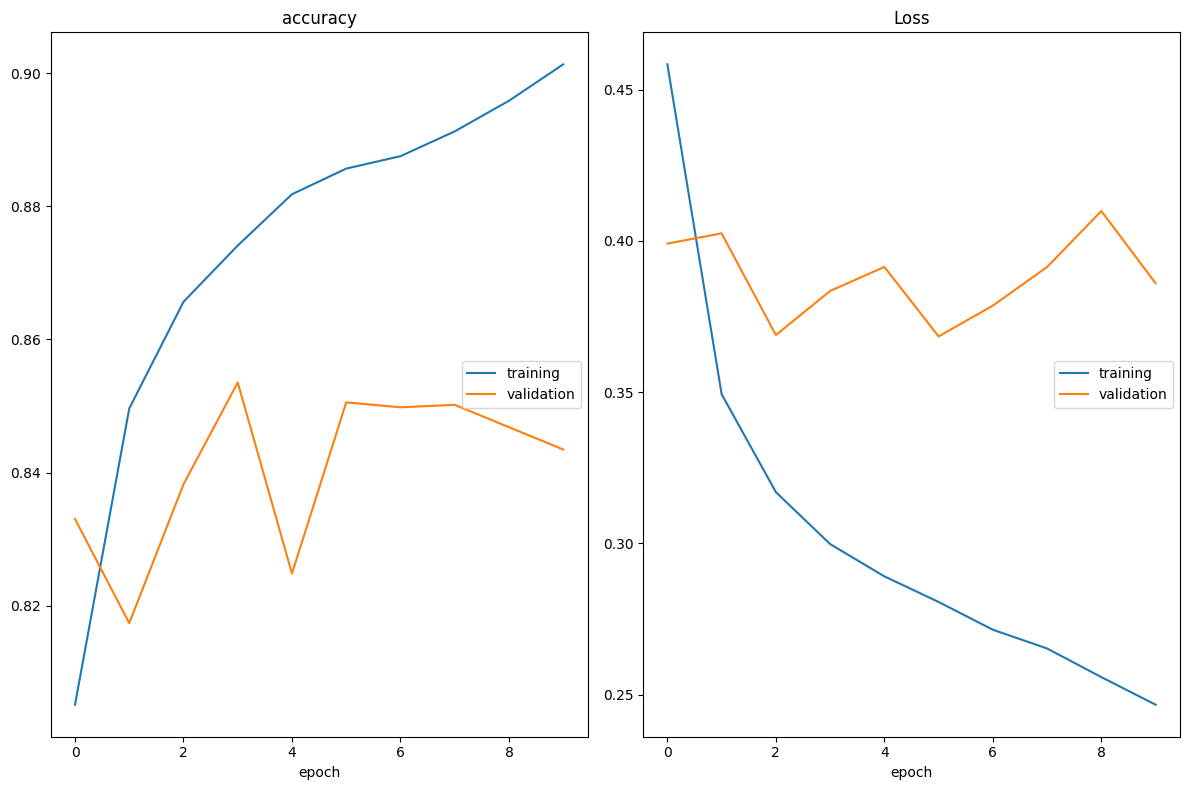

accuracy
	training         	 (min:    0.805, max:    0.901, cur:    0.901)
	validation       	 (min:    0.817, max:    0.854, cur:    0.843)
Loss
	training         	 (min:    0.247, max:    0.458, cur:    0.247)
	validation       	 (min:    0.368, max:    0.410, cur:    0.386)
252/252 [==============================] - 6s 23ms/step - loss: 0.2467 - accuracy: 0.9013 - val_loss: 0.3860 - val_accuracy: 0.8435


In [51]:

model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[PlotLossesKerasTF()]
)

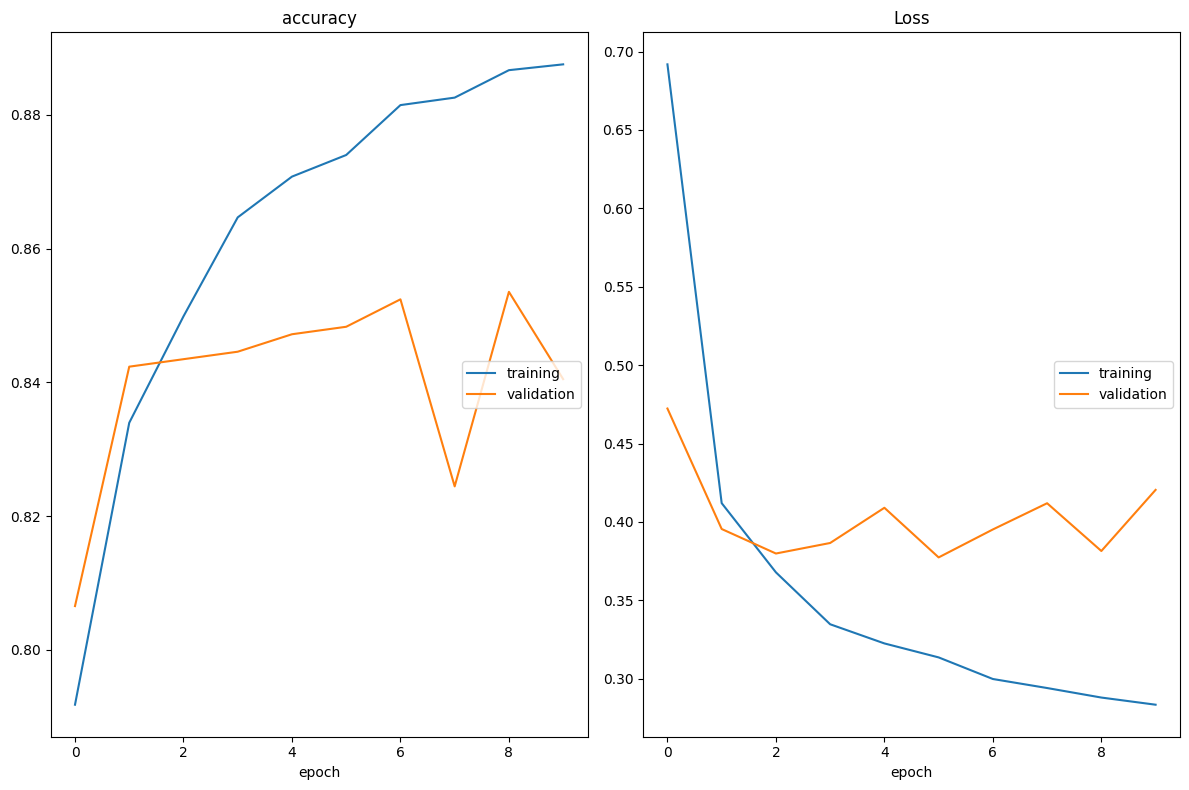

accuracy
	training         	 (min:    0.792, max:    0.888, cur:    0.888)
	validation       	 (min:    0.807, max:    0.854, cur:    0.840)
Loss
	training         	 (min:    0.283, max:    0.692, cur:    0.283)
	validation       	 (min:    0.377, max:    0.472, cur:    0.420)
252/252 [==============================] - 5s 20ms/step - loss: 0.2834 - accuracy: 0.8875 - val_loss: 0.4204 - val_accuracy: 0.8405


In [56]:
# model is overfitting, lets regularize it
from tensorflow.keras.regularizers import l2
# build model
model= Sequential()
model.add(Embedding(input_dim=NUM_WORDS,output_dim=128))
model.add(LSTM(32,kernel_regularizer=l2(0.01)))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy'])
model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test,y_test),
    callbacks=[PlotLossesKerasTF()]
)

In [53]:
# Apply model
new_data = pd.DataFrame({"Tweet":["nice debate, we should get more speakers like that.","Worst speakers possible in the debate"]})

In [54]:
#preprocess
new_data["cleaned_tweet"]=new_data['Tweet'].apply(cleanText)

In [57]:
# convert to seq
new_data_seq = tk.texts_to_sequences(new_data['cleaned_tweet'])
new_data_seq

[[529, 7, 20, 9], [593, 1402, 7]]

In [58]:
# check model performance
from sklearn.metrics import classification_report

In [59]:
# make predictions
# if prediction >= 0.5 --> 1 else 0
y_train_pred = np.where(model.predict(x_train).flatten()>=0.5,1,0) 

252/252 [==============================] - 2s 5ms/step


In [60]:
y_test_pred = np.where(model.predict(x_test).flatten()>=0.5,1,0)

84/84 [==============================] - 0s 4ms/step


In [61]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92      6369
           1       0.90      0.42      0.57      1677

    accuracy                           0.87      8046
   macro avg       0.88      0.70      0.75      8046
weighted avg       0.87      0.87      0.85      8046



In [62]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      2124
           1       0.77      0.33      0.46       559

    accuracy                           0.84      2683
   macro avg       0.81      0.65      0.68      2683
weighted avg       0.83      0.84      0.81      2683



In [63]:
y.value_counts()

0    8493
1    2236
Name: sentiment, dtype: int64

In [64]:
y_train.value_counts()

0    6369
1    1677
Name: sentiment, dtype: int64

In [65]:
# model is still overfitting, lets regularize it and check other metrics
from tensorflow.keras.metrics import Precision, Recall
# build model
model= Sequential()
model.add(Embedding(input_dim=NUM_WORDS,output_dim=128))
model.add(LSTM(25,kernel_regularizer=l2(0.01)))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy',Precision(),Recall()])

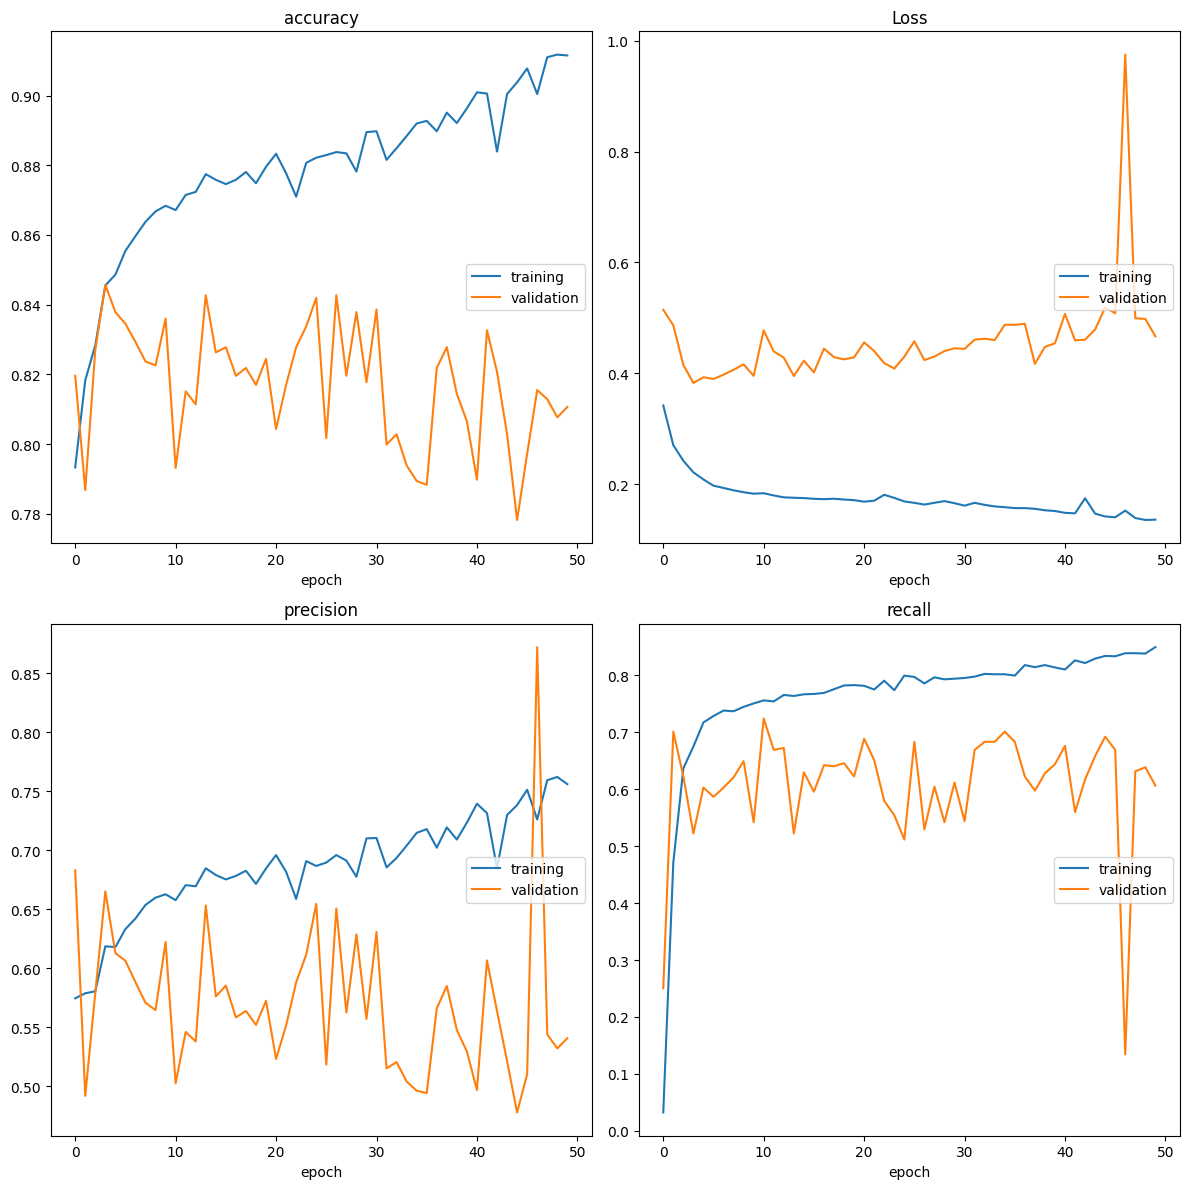

accuracy
	training         	 (min:    0.793, max:    0.912, cur:    0.912)
	validation       	 (min:    0.778, max:    0.846, cur:    0.811)
Loss
	training         	 (min:    0.135, max:    0.342, cur:    0.136)
	validation       	 (min:    0.383, max:    0.975, cur:    0.467)
precision
	training         	 (min:    0.574, max:    0.762, cur:    0.756)
	validation       	 (min:    0.478, max:    0.872, cur:    0.541)
recall
	training         	 (min:    0.032, max:    0.850, cur:    0.850)
	validation       	 (min:    0.134, max:    0.725, cur:    0.606)
252/252 [==============================] - 5s 21ms/step - loss: 0.1359 - accuracy: 0.9115 - precision: 0.7560 - recall: 0.8497 - val_loss: 0.4666 - val_accuracy: 0.8107 - val_precision: 0.5407 - val_recall: 0.6064


In [67]:
model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test,y_test),
    callbacks=[PlotLossesKerasTF()],
    class_weight={0:0.4,1:0.9}  # Add more weight to positive sentiment predictions because previous accuracy for class 1 was much weaker
)

# GRU
Updated LSTM architecture to better weight previous tokens

In [68]:
# build model
from tensorflow.keras.layers import GRU
model= Sequential()
model.add(Embedding(input_dim=NUM_WORDS,output_dim=128))
model.add(GRU(25,kernel_regularizer=l2(0.01)))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy',Precision(),Recall()])

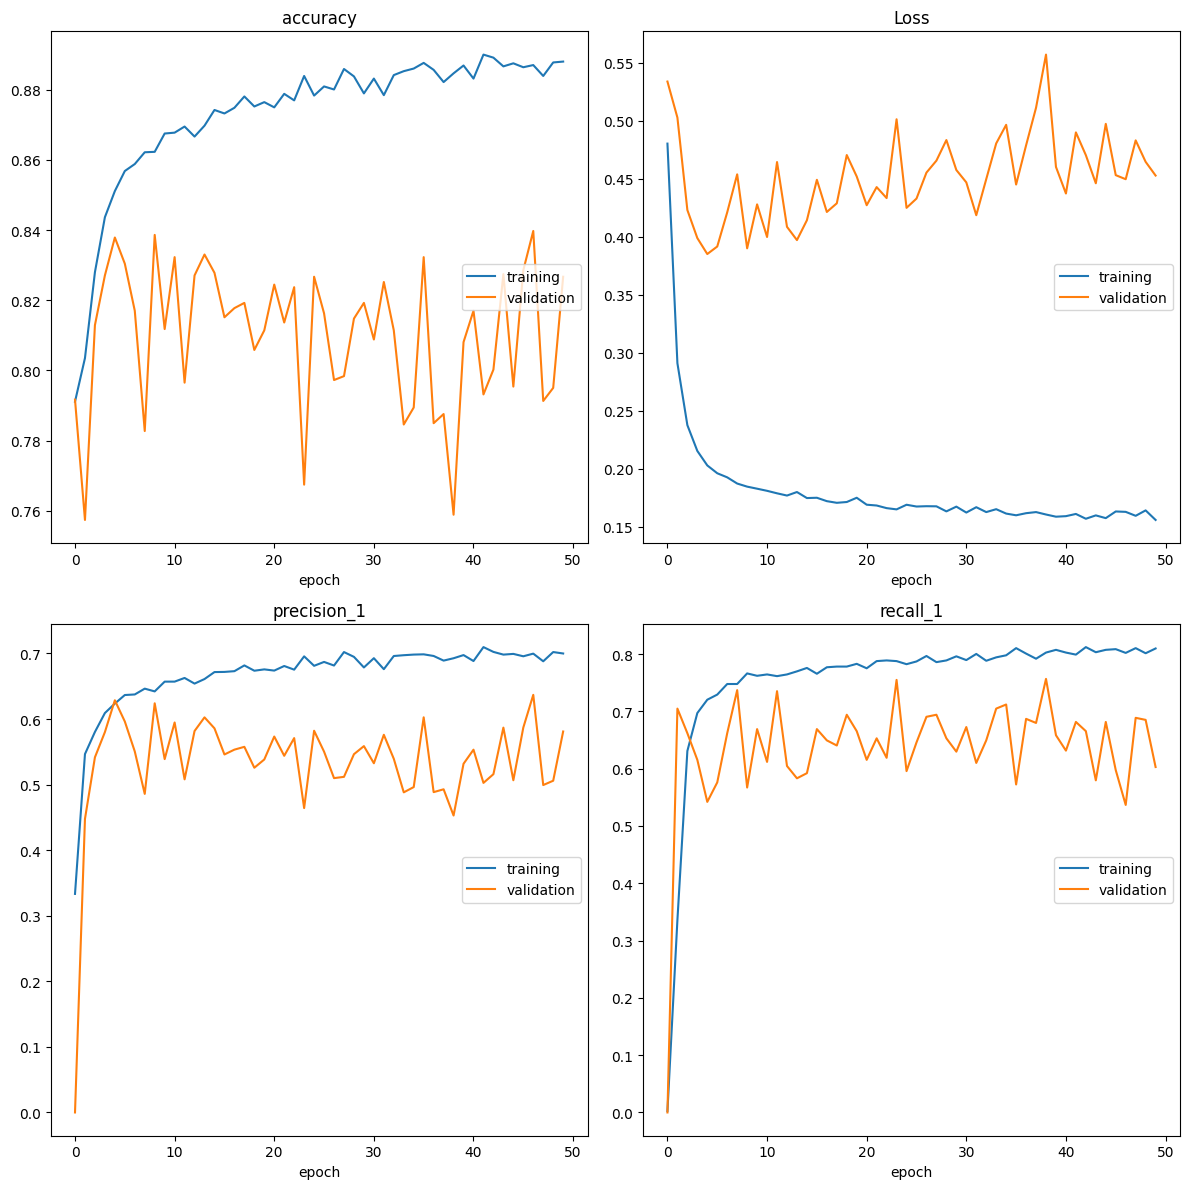

accuracy
	training         	 (min:    0.791, max:    0.890, cur:    0.888)
	validation       	 (min:    0.757, max:    0.840, cur:    0.827)
Loss
	training         	 (min:    0.156, max:    0.480, cur:    0.156)
	validation       	 (min:    0.385, max:    0.557, cur:    0.453)
precision_1
	training         	 (min:    0.333, max:    0.710, cur:    0.700)
	validation       	 (min:    0.000, max:    0.637, cur:    0.581)
recall_1
	training         	 (min:    0.002, max:    0.812, cur:    0.810)
	validation       	 (min:    0.000, max:    0.757, cur:    0.603)
252/252 [==============================] - 5s 20ms/step - loss: 0.1559 - accuracy: 0.8880 - precision_1: 0.7000 - recall_1: 0.8098 - val_loss: 0.4529 - val_accuracy: 0.8267 - val_precision_1: 0.5810 - val_recall_1: 0.6029


In [69]:
model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test,y_test),
    callbacks=[PlotLossesKerasTF()],
    class_weight={0:0.4,1:0.9}  # Add more weight to positive sentiment predictions because previous accuracy for class 1 was much weaker
)